In [1]:
dataset_name = "REDDIT-BINARY"
data_path = "./"
num_epochs = 400
batch_size = 128
learning_rate = 0.01
num_hidden = 64
lam_range = [0.005, 0.01]
aug_ratio = 0.15
aug_num = 10
seed = 6

**Packages**

In [2]:
!python --version

Python 3.10.12


In [3]:
# to install the correct version of Pytorch Geometric on Goolge Colab
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html


In [4]:
from typing import List, Tuple
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import copy
import random
from math import ceil
import cv2
from time import time
import logging
import os
import os.path as osp
import random
import argparse

import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, global_mean_pool, JumpingKnowledge
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import GCNConv, global_mean_pool, JumpingKnowledge
from torch_geometric.nn import SAGEConv, global_mean_pool, JumpingKnowledge
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, JumpingKnowledge
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool, dense_diff_pool
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import degree, to_dense_adj
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

In [5]:
def pad_graphs(max_num, sorted_node_degree, sorted_graph, index):
    normal_node_degree = np.zeros((max_num, 1))
    aligned_graph = np.zeros((max_num, max_num))

    normal_node_degree[:index, :] = sorted_node_degree
    aligned_graph[:index, :index] = sorted_graph

    return normal_node_degree, aligned_graph


In [6]:
# sorting graphs nodes by descending node degrees to align them
def sort_graphs(graphs: List[np.ndarray], padding: bool = False, N: int = None):
    num_nodes = []
    for i in range(len(graphs)):
        num_nodes.append(graphs[i].shape[0])

    max_num = max(N if N is not None else -np.inf, max(num_nodes))

    # aligned adjacency matrices
    aligned_graphs = []
    # sorted normalized node degrees (as node distributions)
    normal_node_degrees = []
    for i in range(len(graphs)):

        node_degree = 0.5 * np.sum(graphs[i], axis=0) + 0.5 * np.sum(graphs[i], axis=1)
        node_degree_avg = node_degree/np.sum(node_degree)
        asc_idx = np.argsort(node_degree_avg)
        desc_idx = asc_idx[::-1]

        sorted_node_degree = node_degree[desc_idx]
        sorted_node_degree = sorted_node_degree.reshape(-1, 1)

        sorted_graph = copy.deepcopy(graphs[i])
        sorted_graph = sorted_graph[desc_idx, :]
        sorted_graph = sorted_graph[:, desc_idx]

        if padding:
            num_i = num_nodes[i]
            normalized_node_degree, aligned_graph = pad_graphs(max_num, sorted_node_degree, sorted_graph, num_i)

            normal_node_degrees.append(normalized_node_degree)
            aligned_graphs.append(aligned_graph)

        else:
            normal_node_degrees.append(sorted_node_degree)
            aligned_graphs.append(sorted_graph)

        if N != 0:
            normal_node_degrees = normal_node_degrees[:N]
            aligned_graphs = [aligned_graph[:N, :N] for aligned_graph in aligned_graphs]

    # Tuple[List[np.ndarray], List[np.ndarray], int, int]
    return aligned_graphs, normal_node_degrees

In [7]:
def graphons_generation(two_graphons, la=0.5, num_sample=20):

    first_graphon_label = two_graphons[0][0]
    first_graphon = two_graphons[0][1]

    second_graphon_label = two_graphons[1][0]
    second_graphon = two_graphons[1][1]

    label = la * first_graphon_label + (1 - la) * second_graphon_label
    new_graphon = la * first_graphon + (1 - la) * second_graphon

    mixed_up_label = torch.from_numpy(label).type(torch.float32)

    graphons = []
    for i in range(num_sample):

        graphon = np.random.rand(*new_graphon.shape) <= new_graphon
        graphon = graphon.astype(np.int32)
        graphon = np.triu(graphon)
        graphon = graphon + graphon.T - np.diag(np.diag(graphon))

        graphon = graphon[graphon.sum(axis=1) != 0]
        graphon = graphon[:, graphon.sum(axis=0) != 0]

        edge_index, _ = dense_to_sparse(torch.from_numpy(graphon))

        new_graph = Data()
        new_graph.y = mixed_up_label
        new_graph.edge_index= edge_index
        new_graph.num_nodes = int(torch.max(edge_index)) + 1
        graphons.append(new_graph)

    return graphons

In [8]:
# Splits the class of graohs
def split_class(dataset):

    data_y_list = []
    for data in dataset:
        y = tuple(data.y.tolist())
        data_y_list.append(y)

    all_graphs_list = []
    for data in dataset:
        graph = to_dense_adj(data.edge_index)
        all_graphs_list.append(graph[0].numpy())

    class_graphs = []
    for class_label in set(data_y_list):
        c_graph_list = []
        for i in range(len(data_y_list)):
            if data_y_list[i] == class_label:
                c_graph_list.append(all_graphs_list[i])
        class_graphs.append( ( np.array(class_label), c_graph_list ) )

    return class_graphs

In [9]:
def graph_resolution(graphs_list: List[Data]):
    num_total_nodes = []
    for graph in graphs_list:
        num_total_nodes.append(graph.num_nodes)

    median_num_nodes = np.median( num_total_nodes )
    resolution = int(median_num_nodes)

    return resolution

In [10]:
# Estimate a graphon by USV
def svd(sorted_graphs: List[np.ndarray], threshold: float = 0.2):

    sorted_graphs =  torch.from_numpy(np.array(sorted_graphs)).float()

    if sorted_graphs.size(0) < 1:
      sum_graph = sorted_graphs[0, :, :]
    else:
      sum_graph = torch.mean(sorted_graphs, dim=0)

    u, s, v = torch.svd(sum_graph)
    singular_threshold = threshold * (sum_graph.size(0) ** 0.5)
    s[torch.lt(s, singular_threshold)] = 0
    graphon = u @ torch.diag(s) @ torch.t(v)
    graphon[graphon > 1] = 1
    graphon[graphon < 0] = 0
    graphon = graphon.numpy()
    # (r, r) graphon model
    # np.ndarray
    return graphon

**Model**

In [11]:
class GIN(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=1, num_hidden=64):
        super(GIN, self).__init__()

        dim = num_hidden

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

**Mixup**

In [12]:
def prepare_data_x(dataset):

    if dataset[0].x is None:
        max_deg = 0
        degrees = []
        for data in dataset:
            degrees += [degree(data.edge_index[0], dtype=torch.long)]
            max_deg = max( max_deg, degrees[-1].max().item() )
            data.num_nodes = int( torch.max(data.edge_index) ) + 1

        if max_deg > 2000:
            deg = torch.cat(degrees, dim=0).to(torch.float)
            mean = deg.mean().item()
            std = deg.std().item()
            for data in dataset:
                degrees = degree(data.edge_index[0], dtype=torch.long)
                data.x = ( (degrees - mean) / std ).view( -1, 1 )

        else:
          for data in dataset:
                degrees = degree(data.edge_index[0], dtype=torch.long)
                data.x = F.one_hot(degrees, num_classes=max_deg + 1).to(torch.float)

    return dataset

In [13]:
# Onehots y
def prepare_data_y(dataset):
    for data in dataset:
        data.y = F.one_hot(data.y, num_classes=len(dataset)).to(torch.float)[0]
    return dataset

In [14]:
def cross_entropy_loss(input, labels, size_average=True):

    assert input.size() == labels.size()
    assert isinstance(input, Variable) and isinstance(labels, Variable)
    loss = - torch.sum(input * labels)

    return loss / input.size()[0] if size_average else loss

In [15]:
def train(model, dataset):
    model.train()
    loss_total = 0
    graph_total = 0
    for data in dataset:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, num_classes)
        loss = cross_entropy_loss(output, y)
        loss.backward()
        loss_total += loss.item() * data.num_graphs
        graph_total += data.num_graphs
        optimizer.step()
    return model, loss_total / graph_total

In [16]:
def test(model, dataset):
    model.eval()
    accurate = 0
    total = 0
    loss = 0
    for data in dataset:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, num_classes)
        num_graphs = data.num_graphs
        loss += cross_entropy_loss(output, y).item() * num_graphs
        y = y.max(dim=1)[1]
        accurate += pred.eq(y).sum().item()
        total += num_graphs
    return accurate / total, loss / total


In [17]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s: - %(message)s', datefmt='%Y-%m-%d')

torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"This is running on: {device}")

if not (dataset_name == "IMDB-BINARY" or dataset_name == "IMDB-MULTI" or
        dataset_name == "REDDIT-BINARY" or dataset_name == "REDDIT-MULTI-5K" or
        dataset_name == "REDDIT-MULTI-12K"):
  raise ValueError("Data type is not correct")

dataset = TUDataset(data_path+dataset_name, name=dataset_name)

dataset = prepare_data_y(list(dataset))

train_nums = int(len(dataset) * 0.7)
train_val_nums = int(len(dataset) * 0.8)

random.seed(seed)
random.shuffle( dataset )

resolution = graph_resolution(dataset[: train_nums])

dataset_before_gmixup = prepare_data_x( dataset )

logger.info(f"num_features_before_gmixup: {dataset_before_gmixup[0].x.shape}" )
logger.info(f"num_classes_before_gmixup: {dataset_before_gmixup[0].y.shape}"  )

# GMixup
class_graphs = split_class(dataset[:train_nums])
graphons = []
for label, graphs in class_graphs:

  align_graphs_list, normalized_node_degree = sort_graphs(graphs, padding=True, N=resolution)

  graphon = svd(align_graphs_list)
  graphons.append((label, graphon))

num_sample = int( train_nums * aug_ratio / aug_num )
lams = np.random.uniform(low=lam_range[0], high=lam_range[1], size=(aug_num,))

random.seed(seed)
new_graph = []
for lam in lams:
  two_graphons = random.sample(graphons, 2)
  new_graph += graphons_generation(two_graphons, la=lam, num_sample=num_sample)

dataset = new_graph + dataset
train_nums = train_nums + len( new_graph )
train_val_nums = train_val_nums + len( new_graph )

dataset_after_gmixup = prepare_data_x( dataset )

num_features = dataset_after_gmixup[0].x.shape[1]
num_classes = dataset_after_gmixup[0].y.shape[0]
logger.info(f"num_features_after_gmixup: {num_features}" )
logger.info(f"num_classes_after_gmixup: {num_classes}"  )

random.shuffle(dataset_after_gmixup)
train_dataset = dataset_after_gmixup[:train_nums]
random.shuffle(train_dataset)
val_dataset = dataset_after_gmixup[train_nums:train_nums+train_val_nums]
test_dataset = dataset_after_gmixup[train_val_nums:]


train_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = DataLoader(test_dataset, batch_size=batch_size)


model = GIN(num_features=num_features, num_classes=num_classes, num_hidden=num_hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
lr_scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

train_l = []
test_l = []
val_l = []
val_a = []
test_a = []
model.to(device)

for epoch in range(1, num_epochs):
        model, train_loss = train(model, train_dataset)
        val_acc, val_loss = test(model, val_dataset)
        test_acc, test_loss = test(model, test_dataset)
        lr_scheduler.step()

        train_l.append(train_loss)
        test_l.append(test_loss)
        val_l.append(val_loss)
        test_a.append(test_acc)
        val_a.append(val_acc)

        logger.info('Epoch: {:03d}, Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f},  Val Acc: {: .6f}, Test Acc: {: .6f}'.format(
            epoch, train_loss, val_loss, test_loss, val_acc, test_acc))


INFO:root:This is running on: cuda
DEBUG:fsspec.local:open file: /content/REDDIT-BINARY/REDDIT-BINARY/processed/data.pt
INFO:root:num_features_before_gmixup: torch.Size([1246, 1])
INFO:root:num_classes_before_gmixup: torch.Size([2000])
INFO:root:num_features_after_gmixup: 1
INFO:root:num_classes_after_gmixup: 2000
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO:root:Epoch: 001, Train Loss: 3.599637, Val Loss: 1.129928, Test Loss: 1.215616,  Val Acc:  0.488333, Test Acc:  0.482500
INFO:root:Epoch: 002, Train Loss: 0.708519, Val Loss: 0.807697, Test Loss: 0.811398,  Val Acc:  0.553333, Test Acc:  0.560000
INFO:root:Epoch: 003, Train Loss: 0.525971, Val Loss: 0.531046, Test Loss: 0.524304,  Val Acc:  0.713333, Test Acc:  0.712500
INFO:root:Epoch: 004, Train Loss: 0.497297, Val Loss: 0.510006, Test Loss: 0.509026,  Val Acc:  0.756667, Test Acc:  0.745000
INFO:r

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/us

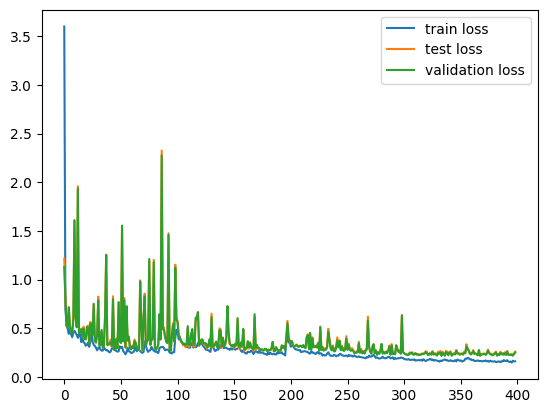

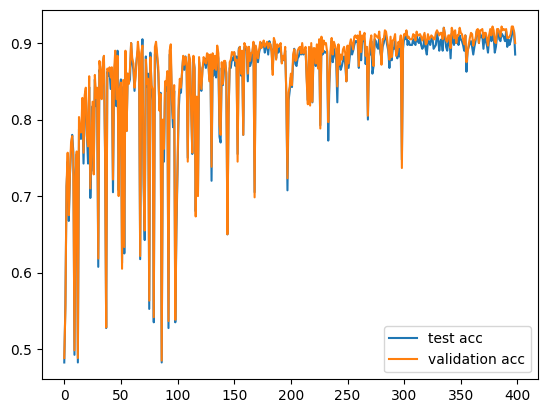

In [18]:
plt.plot(train_l[:], label="train loss")
plt.plot(test_l[:], label="test loss")
plt.plot(val_l[:], label="validation loss")
plt.legend()
plt.show()

plt.plot(test_a[:], label="test acc")
plt.plot(val_a[:], label="validation acc")
plt.legend()
plt.show()